In [25]:
import os
import pandas as pd
import re
import tempun
import matplotlib.pyplot as plt
import json

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [7]:
service_accounts_key_path = "../../../ServiceAccountsKey.json" # change to fit your location
file_data = json.load(open(service_accounts_key_path))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

noscemus_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1ekf9RBfd4yqy0p0IWJ4SDk1kUT70hnoIVX1H6KPdIts/edit?usp=sharing")

The raw data for Corpus Corporum have been downloaded in terminal using these two commands:
* `sudo curl -L -o /srv/data/corpus-corporum/latin_raw.csv "https://huggingface.co/datasets/Fece228/latin-literature-dataset-170M/resolve/main/latin_raw.csv?download=true"`
* `sudo curl -L -o /srv/data/corpus-corporum/latin_lemmas.csv "https://huggingface.co/datasets/Fece228/latin-literature-dataset-170M/resolve/main/latin_lemmas.csv?download=true"`

In [8]:
cc_raw = pd.read_csv('/srv/data/corpus-corporum/latin_raw.csv')

In [10]:
cc_raw.head(5)

,Unnamed: 0,title,text,author,year,word_count
0,latin_xmls\10.xml,De facto Ungarie magne1236\n,\n\nDe facto Ungarie magne\n\na fratre Riccard...,Riccardus OFM,fl.1236,3340
1,latin_xmls\100.xml,De trinitate,\n\n ARGUMENTUM.\n\n\n #Dividitur tract...,Novatianus,fl. 260,44792
2,latin_xmls\10000.xml,De quadratura circuli,\n\n\n NOTA.\nDiximus falso videri Be...,Franco Leodiensis,NaN,1648
3,latin_xmls\10001.xml,Epistola ad Berengarium,\n\n Epistola ad Berengarium\n\nDomino ...,Frollandus Sylvanectensis,NaN,518
4,latin_xmls\10002.xml,Diplomata,\n\n I. #Charta fundationis seu restitu...,Gervasius Remensis1055-1067,1055-1067,1532


In [19]:
len(cc_raw)

7819

In [20]:
# let's use the numeric component from "Unnamed: 0" as a source for a Corpus Corporum ID
cc_raw["cc_id"] = cc_raw["Unnamed: 0"].apply(lambda x: x.rpartition("\\")[2].replace(".xml", ""))

In [21]:
# check that we have identical number of IDs as the number of works
len(set(cc_raw["cc_id"]))

7819

In [44]:
cc_raw.set_index("cc_id", inplace=True)

In [9]:
cc_raw["word_count"] = cc_raw["text"].apply(lambda x: len(x.split()))

In [5]:
cc_raw["word_count"].sum()

470180378

In [22]:
cc_raw.shape

(7819, 7)

In [27]:
source_path = "/srv/data/corpus-corporum/cc_rawtexts/"
try:
    os.mkdir(source_path)
except:
    pass

In [28]:
os.listdir("/srv/data/corpus-corporum")

['latin_lemmas.csv', 'cc_rawtexts', 'latin_raw.csv']

In [30]:
# save the raw texts into independent files...

def save_text_to_file(row, path=source_path):
    text = row["text"]
    filename = row["cc_id"] + ".txt"
    full_path = os.path.join(path, filename)
    with open(full_path, "w") as f:
        f.write(text)

cc_raw.apply(lambda row: save_text_to_file(row), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
7814    None
7815    None
7816    None
7817    None
7818    None
Length: 7819, dtype: object

In [31]:
# look at what we got...
os.listdir(source_path)[:10]

['11862.txt',
 '15393.txt',
 '8089.txt',
 '20102.txt',
 '7275.txt',
 '10052.txt',
 '10765.txt',
 '7562.txt',
 '11896.txt',
 '9411.txt']

In [32]:
len(os.listdir(source_path))

7819

In [33]:
# drop the textual column from actual table
cc_raw.drop(["text", "Unnamed: 0"], axis=1, inplace=True)

In [45]:
cc_raw.head(5)

,title,author,year,word_count,not_before,not_after
cc_id,,,,,,
10,De facto Ungarie magne1236\n,Riccardus OFM,fl.1236,3340,1236.0,1236.0
100,De trinitate,Novatianus,fl. 260,44792,260.0,260.0
10000,De quadratura circuli,Franco Leodiensis,NaN,1648,NaN,NaN
10001,Epistola ad Berengarium,Frollandus Sylvanectensis,NaN,518,NaN,NaN
10002,Diplomata,Gervasius Remensis1055-1067,1055-1067,1532,1055.0,1067.0


In [35]:
# TO-DO
cc_raw["year"].apply(lambda x: "post" in str(x)).sum()

3

In [36]:
d = "c. 123"
dates_raw = [el for el in re.findall("(\d+)(BC)?", d)]
dates = []
for tup in dates_raw:
    if tup[1] == "BC":
        dates.append(int(tup[0]) * -1)
    else:
        dates.append(int(tup[0]))
dates

[123]

In [37]:
# clean the dates into an interval, deliminated by "not_before" and "not_after"
def get_dates(d):
    date_dict = {}
    try:
        dates_raw = [el for el in re.findall("(\d+)(BC)?", d)]
        dates = []
        for tup in dates_raw:
            if tup[1] == "BC":
                dates.append(int(tup[0]) * -1)
            else:
                dates.append(int(tup[0]))
    except:
        dates = []
    if len(dates)==1:
        dates = [dates[0], dates[0]]
    if len(dates)==2:
        date_dict = {"not_before" : dates[0], "not_after" : dates[1]}
    else:
        date_dict = {"not_before" : None, "not_after" : None}
    return date_dict   

In [47]:
# look at texts from before the common era
cc_raw[cc_raw["year"].apply(lambda x: "BC" in str(x))]

,title,author,year,word_count,not_before,not_after
cc_id,,,,,,
12144,De agricultura,Varro,116BC-27BC,106464,-116.0,-27.0
12146,De bello Africo,Ps-Caesar,c.50BC,26406,-50.0,-50.0
12147,De bello Alexandrino,Ps-Caesar,c.50BC,21196,-50.0,-50.0
12148,De bello Hispaniensi,Ps-Caesar,c.50BC,12368,-50.0,-50.0
12157,De legibus,icero,106BC–43BC,56574,-106.0,-43.0
...,...,...,...,...,...,...
21315,Theaetetus,Plato,c.425BC–347BC,71198,-425.0,-347.0
21316,Theages,Plato,c.425BC–347BC,10973,-425.0,-347.0
21317,Theogonia,Hesiodus,fl.c.700BC,14234,-700.0,-700.0


In [48]:
cc_raw["dates_dict"] = cc_raw["year"].apply(get_dates)
cc_raw["not_before"] =  cc_raw["dates_dict"].apply(lambda x: x["not_before"])
cc_raw["not_after"] =  cc_raw["dates_dict"].apply(lambda x: x["not_after"])
cc_raw.drop(["dates_dict"], axis=1, inplace=True)

In [49]:
cc_raw.head()

,title,author,year,word_count,not_before,not_after
cc_id,,,,,,
10,De facto Ungarie magne1236\n,Riccardus OFM,fl.1236,3340,1236.0,1236.0
100,De trinitate,Novatianus,fl. 260,44792,260.0,260.0
10000,De quadratura circuli,Franco Leodiensis,NaN,1648,NaN,NaN
10001,Epistola ad Berengarium,Frollandus Sylvanectensis,NaN,518,NaN,NaN
10002,Diplomata,Gervasius Remensis1055-1067,1055-1067,1532,1055.0,1067.0


In [50]:
cc_raw["is_earlymodern"] = ((cc_raw["not_after"]>=1501)
 & (cc_raw["not_before"]<=1800))

In [51]:
cc_raw["is_earlymodern"].sum()

702

In [52]:
cc_raw[cc_raw["is_earlymodern"]]["word_count"].sum()

62656530

In [53]:
"; ".join(list(cc_raw[cc_raw["is_earlymodern"]]["author"].unique()))

"Thomas Morus; Cartesius, Renatus; Desiderius Erasmus; Maurolycus, Franciscus; Kircher, Athanasius; Eberhard Schleusinger; Vesalius, Andreas; Leibniz, Gottfried Wilhelm; Copernicus, Nicolaus; Lavater, Ludwig; Cardanus, Hieronymus; Cantemir, Demetrius; Franciscus Suarez; Bene, Franz von; Benedictus Spinoza; Giambattista della Porta; Francis Bacon; Galilei, Galileo; Johannes Kepler; Kepler, Iohannes; Giordano Bruno; Gianni Battista Cantalicio; Baldassarre Castiglione; Giacomo Leopardi; Giambattista Giraldi Cinzio; Antonio Maria Conti; Gianfrancesco Pico della Mirandola; Uberto Foglietta; Lilio Gregorio Giraldi; Sannazaro, Iacopo; Ugolino Verino; Ugo Foscolo; Ludovico Ariosto; Torquato Tasso; Ludovico Carbone; Anonymus ; Andronicus, Parthenius Tranquillus; Cunichius, Raymondus; Leuakouicz, Raphael; Marulus Spalatensis, Marcus; Gradius, Stephanus; Verantius, Michael; Skerletz, Nicolaus; Pridojevich, Iohannes; Cibel, Valentin; Eborensis, Iacobus Flavius; Ritter, Paulus; Verhovac, Maximilian

In [54]:
cc_raw["random_dates"] = cc_raw.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100), axis=1)

[[<matplotlib.patches.Polygon at 0x7e5d46774c70>],

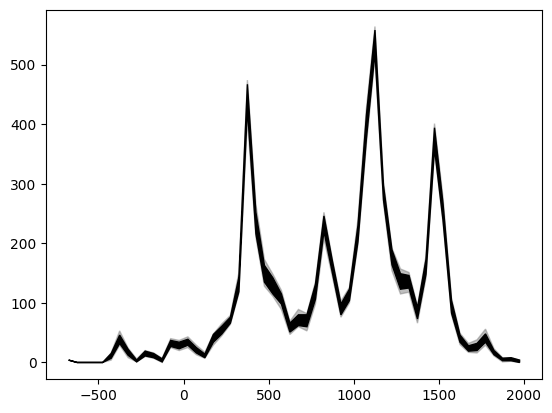

In [55]:
tempun.timeblocksplot_from_randoms(cc_raw["random_dates"])

### Explore wordcount distributions

In [56]:
def wordcount(timeblock_df, column="word_count"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].sum()
wordcounts_data = tempun.sim_data_by_function(cc_raw, 100, [-200, 1900, 50], wordcount)

In [57]:
cc_raw["late-ant"] = ((cc_raw["not_after"]>=250)
                            & (cc_raw["not_before"]<=450))

In [58]:
cc_raw[cc_raw["late-ant"]].groupby("author").size().sort_values(ascending=False)

author
Augustinus Hipponensis             199
Hieronymus Stridonensis             99
Ambrosius Mediolanensis             53
Ausonius Burdigalensis              45
Hilarius Pictaviensis               26
                                  ... 
Victor Vitensis430-484               1
Iulius Victor                        1
Julianus Pomerius430-490             1
Julius Firmicus Maternusfl.337       1
Iulius Exuperantius                  1
Length: 188, dtype: int64

In [59]:
cc_raw[cc_raw["title"].str.contains("Homili")]

,title,author,year,word_count,not_before,not_after,is_earlymodern,random_dates,late-ant
cc_id,,,,,,,,,
10558,Homiliae,Radulfus Ardens-c.1200,-c.1200,388054,1200.0,1200.0,False,"[1200, 1200, 1200, 1200, 1200, 1200, 1200, 120...",False
10622,Homiliae et exhortationes,Anselmus Cantuariensis,1033-1109,75062,1033.0,1109.0,False,"[1099, 1094, 1082, 1091, 1079, 1083, 1045, 105...",False
10703,Homilia de villico iniquitatis,Odo Cameracensis-1113,-1113,4268,1113.0,1113.0,False,"[1113, 1113, 1113, 1113, 1113, 1113, 1113, 111...",False
11042,Homiliae dominicales,Godefridus Admontensis-1165,-1165,507076,1165.0,1165.0,False,"[1165, 1165, 1165, 1165, 1165, 1165, 1165, 116...",False
11043,Homiliae festivales,Godefridus Admontensis-1165,-1165,348548,1165.0,1165.0,False,"[1165, 1165, 1165, 1165, 1165, 1165, 1165, 116...",False
11044,Homiliae in diversos locos Scripturae,Godefridus Admontensis-1165,-1165,61134,1165.0,1165.0,False,"[1165, 1165, 1165, 1165, 1165, 1165, 1165, 116...",False
11065,Homiliae in Ecclesiasten,Hugo de S. Victore,-1141,123390,1141.0,1141.0,False,"[1141, 1141, 1141, 1141, 1141, 1141, 1141, 114...",False
11383,Homiliae de Maria Virginea Matre,Amedeus Lausannensis1144-1159,1144-1159,35440,1144.0,1159.0,False,"[1149, 1150, 1155, 1149, 1144, 1152, 1151, 114...",False
11446,Homilia de natalitio martyris die,Herbertus de Boseham-1186,-1186,7956,1186.0,1186.0,False,"[1186, 1186, 1186, 1186, 1186, 1186, 1186, 118...",False


In [60]:
wordcounts_data[0]

[((-200, -151), 341807),
 ((-150, -101), 563066),
 ((-100, -51), 4532562),
 ((-50, -1), 3733144),
 ((1, 50), 2439685),
 ((51, 100), 3769572),
 ((101, 150), 1362629),
 ((151, 200), 1868182),
 ((201, 250), 2338044),
 ((251, 300), 3583410),
 ((301, 350), 11596416),
 ((351, 400), 38495895),
 ((401, 450), 20828979),
 ((451, 500), 9368524),
 ((501, 550), 10195577),
 ((551, 600), 8632119),
 ((601, 650), 3593371),
 ((651, 700), 3519611),
 ((701, 750), 4001486),
 ((751, 800), 7008826),
 ((801, 850), 14784733),
 ((851, 900), 10093835),
 ((901, 950), 4537531),
 ((951, 1000), 2839666),
 ((1001, 1050), 7200549),
 ((1051, 1100), 21956299),
 ((1101, 1150), 37409230),
 ((1151, 1200), 24013087),
 ((1201, 1250), 36221856),
 ((1251, 1300), 17728440),
 ((1301, 1350), 10201337),
 ((1351, 1400), 6182541),
 ((1401, 1450), 2911925),
 ((1451, 1500), 8166855),
 ((1501, 1550), 10624391),
 ((1551, 1600), 17503422),
 ((1601, 1650), 18609995),
 ((1651, 1700), 5071765),
 ((1701, 1750), 3289292),
 ((1751, 1800), 1625

[Text(0, 10000000, '10M'),
 Text(0, 20000000, '20M'),
 Text(0, 30000000, '30M'),
 Text(0, 40000000, '40M'),
 Text(0, 50000000, '50M')]

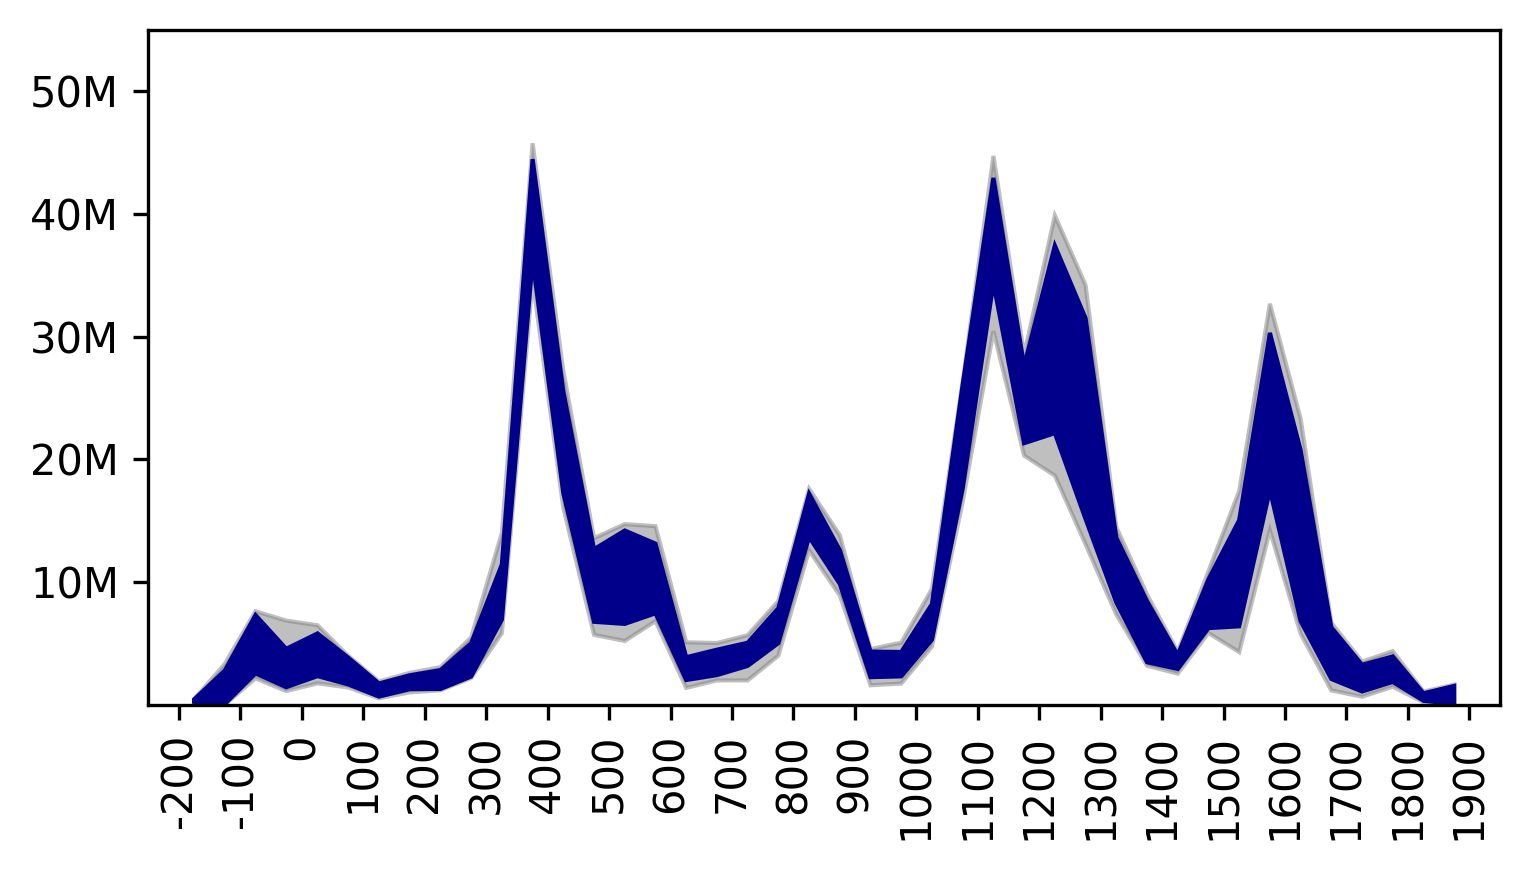

In [61]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
tempun.plot_timeblocks_data(wordcounts_data, ax=ax, color="darkblue")
ax.set_xticks(range(-200,2000,100))
ax.set_xticklabels([str(el) for el in range(-200,2000,100)], rotation=90)
ax.set_xlim(-250, 1950)

ax.set_ylim(0,55000000)
ax.set_yticks(range(10000000, 60000000, 10000000))
ax.set_yticklabels([str(el) + "M" for el in range(10, 60, 10)])


In [62]:
fig.savefig("../figures/corpus-corporum_tempdist.png")

In [63]:
cc_raw.drop("random_dates", axis=1, inplace=True)

In [64]:
cc_raw.head(10)

,title,author,year,word_count,not_before,not_after,is_earlymodern,late-ant
cc_id,,,,,,,,
10,De facto Ungarie magne1236\n,Riccardus OFM,fl.1236,3340,1236.0,1236.0,False,False
100,De trinitate,Novatianus,fl. 260,44792,260.0,260.0,False,True
10000,De quadratura circuli,Franco Leodiensis,NaN,1648,NaN,NaN,False,False
10001,Epistola ad Berengarium,Frollandus Sylvanectensis,NaN,518,NaN,NaN,False,False
10002,Diplomata,Gervasius Remensis1055-1067,1055-1067,1532,1055.0,1067.0,False,False
10003,Epistola ad Valcherum,Gozechinus Scholasticus,fl. 1059,26012,1059.0,1059.0,False,False
10004,Carmen de conflictu ovis et lini,Hermannus Contractus1013-1054,1013-1054,8816,1013.0,1054.0,False,False
10005,Chronicon,Hermannus Contractus1013-1054,1013-1054,161493,1013.0,1054.0,False,False
10006,De mensura astrolabii,Hermannus Contractus1013-1054,1013-1054,9363,1013.0,1054.0,False,False


In [75]:
set_with_dataframe(noscemus_gs.add_worksheet("corpus-corporum", 1,1), cc_raw)